In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#np.set_printoptions(threshold=np.inf)

In [ ]:
# Load in the merged and final data
org_df = pd.read_csv('/content/final_data_reddit_bitcoin.csv',index_col=0)

In [ ]:
org_df

,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,Open,High,Low,Close,Volume,Market Cap
date,,,,,,,,,,,,,
2021-01-31,-0.338142,0.142702,0.293933,0.082990,0.053310,0.863730,0.131805,33082.843766,34599.997674,32402.294129,33513.441196,8.977457e+10,6.271695e+11
2021-02-01,-0.365056,0.063796,0.367415,0.103250,0.042570,0.854120,0.227750,33536.478066,35943.342299,33536.478066,35507.127709,8.675868e+10,6.455592e+11
2021-02-02,-0.295277,0.062161,0.331665,0.077900,0.046300,0.875820,0.154349,35476.141807,37565.357809,35476.141807,37551.934351,8.935275e+10,6.800922e+11
2021-02-03,-0.201320,0.100217,0.345251,0.102490,0.034140,0.863350,0.264711,37659.040572,38734.575564,36321.734428,36938.034865,9.505056e+10,6.983574e+11
2021-02-04,-0.479910,0.093733,0.318363,0.109780,0.041150,0.849050,0.209472,36977.782665,38280.062918,36634.285663,37945.964474,1.001826e+11,6.995421e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,-0.426416,0.041017,0.273642,0.092920,0.070040,0.837000,0.122236,37062.964425,37929.944800,36168.927191,37784.722900,5.773464e+10,7.015914e+11
2022-01-28,-0.510252,0.057192,0.299165,0.108740,0.048031,0.843229,0.207484,37741.928400,38577.996300,37369.209771,38131.823600,4.335900e+10,7.161947e+11
2022-01-29,-0.513946,0.102714,0.300672,0.095232,0.060737,0.844032,0.162518,38161.929090,38287.754600,37412.248098,37937.339000,3.479342e+10,7.187560e+11


In [ ]:
org_df.columns

Index(['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity',
       'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com',
       'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'],
      dtype='object')

In [ ]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 13


In [ ]:
expr_name = 'lstm_bitcoin_prediction_sentiment_analysis_with_reddit_posts'
look_back = 7
lstm_layers = 64
epochs = 5
batch_size = 128

In [ ]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  print(len(dataset)-look_back-1)
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

284
66
Training dataset length  292
Testing dataset length  74
look_back  7


In [ ]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
2/2 [==============================] - 3s 522ms/step - loss: 0.2886 - val_loss: 0.2456
Epoch 2/5
2/2 [==============================] - 0s 38ms/step - loss: 0.1252 - val_loss: 0.0862
Epoch 3/5
2/2 [==============================] - 0s 72ms/step - loss: 0.0471 - val_loss: 0.0238
Epoch 4/5
2/2 [==============================] - 0s 73ms/step - loss: 0.0309 - val_loss: 0.0216
Epoch 5/5
2/2 [==============================] - 0s 110ms/step - loss: 0.0428 - val_loss: 0.0279


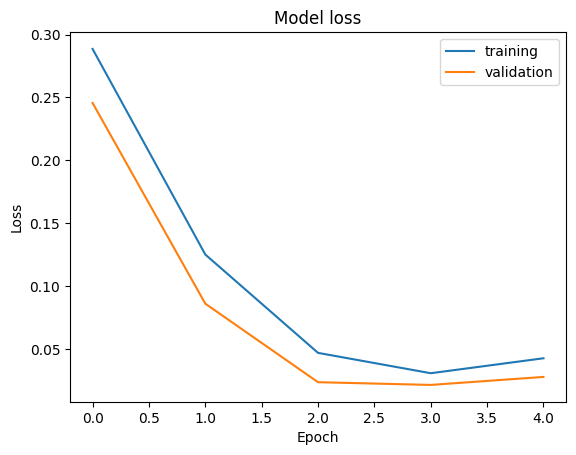

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

3/3 [==============================] - 0s 5ms/step


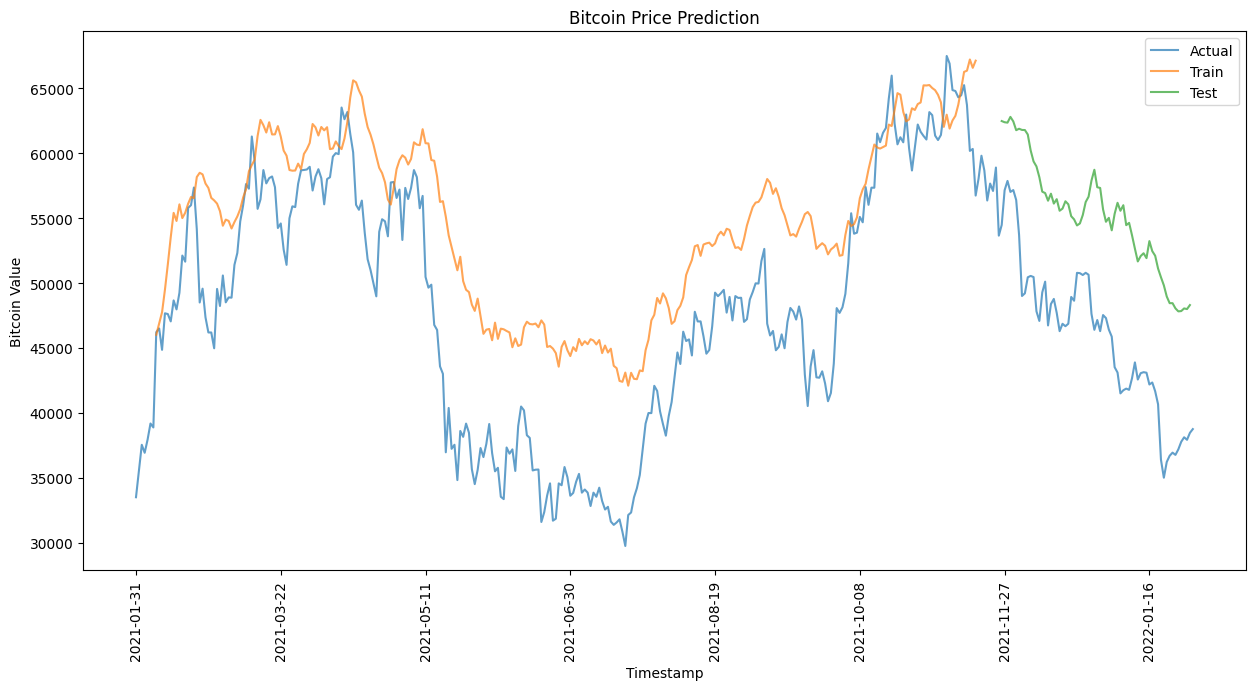

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: lstm_bitcoin_prediction_sentiment_analysis_with_reddit_posts
--------------------------------------------------
look_back days: 0.2916666666666667
lstm_layers: 64
epochs: 5
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
--------------------------------------------------
Train Score: 7750.18 RMSE
Test Score: 9773.70 RMSE
--------------------------------------------------
Train Score: 6583.32 MAE
Test Score: 9406.16 MAE
--------------------------------------------------
Model summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                19968     
                                             